In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, Dropout, Dense
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler


dataset_path = './datasets/Classical/'

In [44]:
import os

dir_path = os.getcwd()
file_list = os.listdir(dir_path)

print(dir_path)
print(file_list)


/Users/seyeong/workspace/Machine-Learning/Multiple_Regression/datasets
['anomaly_detection_model_automation.ipynb', 'model_learning_preset.ipynb', 'datasets']


In [46]:
# npz data to pd.
def npz_to_csv(file_path):
    file = np.load(file_path, allow_pickle=True)
    X_df = pd.DataFrame(file['X'])
    y_df = pd.DataFrame(file['y'])
    return X_df, y_df

# npz_to_csv("/Classical")

Time series 데이터에대하여 Pandas dataframe을 입력으로 받으면 lstm모델로 학습 후, 검증 loss값들과 accuracy값들을 return해주는 함수

In [74]:
from tensorflow.keras.optimizers import legacy
def train_and_evaluate_lstm(X, y, n_splits=5, epochs=30, batch_size=32):
    # 데이터 정규화
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    val_losses = []
    val_accs = []
    
    fold = 1
    for train_idx, test_idx in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Input shape 맞추기 위함
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
        
        model = Sequential()
        model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1), return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(units=1, activation='sigmoid'))

        model.compile(optimizer=legacy.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
        
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
        
        # 가장 좋은 검증 성능을 기록
        best_val_loss = min(history.history['val_loss'])
        best_val_acc = max(history.history['val_accuracy'])
        val_losses.append(best_val_loss)
        val_accs.append(best_val_acc)
        
        print(f"Fold {fold}, Best Validation Loss: {best_val_loss}, Best Validation Accuracy: {best_val_acc}")
        
        fold += 1

    mean_val_loss = np.mean(val_losses)
    mean_val_acc = np.mean(val_accs)
    
    print(f"Mean Best Validation Loss: {mean_val_loss}")
    print(f"Mean Best Validation Accuracy: {mean_val_acc}")
    val_losses.append(mean_val_loss)
    val_accs.append(mean_val_acc)
    
    return val_losses, val_accs

val losses와 val acc를 한 번에 plotting하는 함수

In [69]:
def plot_validation_metrics(val_losses, val_accs):
    num_folds = len(val_losses)
    
    folds = range(1, num_folds + 1)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
    
    ax1.plot(folds, val_losses, marker='o', linestyle='-', color='b')
    ax1.set_ylabel('Validation Loss')
    ax1.set_title('Validation Loss and Accuracy')
    ax1.grid(True)
    
    ax2.plot(folds, val_accs, marker='o', linestyle='-', color='g')
    ax2.set_xlabel('Fold')
    ax2.set_ylabel('Validation Accuracy')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_validation_metrics(fig_name, val_losses, val_accs):
    if not os.path.exists('figure'):
        os.makedirs('figure')
        
    num_folds = len(val_losses)
    
    folds = range(1, num_folds + 1)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
    
    ax1.plot(folds, val_losses, marker='o', linestyle='-', color='b')
    ax1.set_ylabel('Validation Loss')
    ax1.set_title('Validation Loss and Accuracy' + fig_name)
    ax1.grid(True)
    
    ax2.plot(folds, val_accs, marker='o', linestyle='-', color='g')
    ax2.set_xlabel('Fold')
    ax2.set_ylabel('Validation Accuracy')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join('figure', fig_name))
    plt.close() 
    # plt.show()

Anomaly data 비율을 나타내는 함수.
혹시 너무 accuracy가 정확하게 나오는 경우, 모든 데이터셋에 대하여 0이라고 판단했는데 알고보니 레이블이 0인 데이터의 개수가 엄청나게 많을 수 있음.
따라서 항상 의심할 것

In [49]:
def get_anomaly_rate(y):
    return y.value_counts()[1] / (y.value_counts()[0] + y.value_counts()[1])

모든 val_losses와 val_accs를 데이터셋 인덱스에 따라 dictionary로 저장하기 위한 변수

In [50]:
val_dict = {}

In [51]:
def append_to_val_dict(index, val_loss, val_acc):
    val_dict[index] = (val_loss, val_acc)

In [52]:
append_to_val_dict()

TypeError: append_to_val_dict() missing 3 required positional arguments: 'index', 'val_loss', and 'val_acc'

### 데이터 셋 이름 추출



In [61]:
import os
file_list = os.listdir(dataset_path)
file_list.sort()

file_list = file_list[1:]

print(len(file_list))
file_list


33


['34_Turbofan.npz',
 '35_IMS.npz',
 '36_PHM.npz',
 '37_Shutlevalve.npz',
 '38_HSEFilters1.npz',
 '39_HSEFilters2.npz',
 '40_Yahoo1.npz',
 '41_Yahoo2.npz',
 '42_Motorcondition1.npz',
 '43_Motorcondition2.npz',
 '44_HALsteamturbine.npz',
 '45_SWAT.npz',
 '46_Sm4Tankbatch.npz',
 '47_FordB_anreal.npz',
 '48_Ladlefurnace.npz',
 '49_Wafer2.npz',
 '50_PLAID.npz',
 '51_PowerCons.npz',
 '52_Computers.npz',
 '53_Walk2D.npz',
 '54_CNCMachining.npz',
 '55_Boschline.npz',
 '56_ShuttleMarottaValve.npz',
 '57_DutchPowerDemand.npz',
 '58_MiningProcess.npz',
 '59_UCISecom.npz',
 '60_Concrete.npz',
 '61_Biopharmaceutical.npz',
 '62_ECoating.npz',
 '63_Prensas.npz',
 '64_PlasmaSpray.npz',
 '65_MachineryFault.npz',
 '66_Cuttingblade.npz']

In [102]:
# 파일 크기 확인
 
# 파일 단위로 바꾸기
def convert_size(size_bytes):
    import math
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

# 사용 예제
file_size = os.path.getsize(dataset_path + '34_Turbofan.npz') 
print('File Size:', file_size, 'bytes')
a = convert_size(file_size)
a = a.split(' ')
print(float(a[0]))



File Size: 4044166 bytes
3.86


'3.86 MB'

In [114]:
import csv
import pandas as pd

# 파일 저장 경로
csv_file_path = "output.csv"

# CSV 파일에 저장
file_exists = os.path.isfile(csv_file_path)

size_name = ("B", "KB", "MB")
header = ['index', 'fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'mean_fold', 'acc1', 'acc2', 'acc3', 'acc4', 'acc5', 'mean_acc']
for file in file_list:
    f = file.split('_')
    g = file.split('.')
    search_index = int(f[0])

    # CSV 파일에 이미 있는 데이터는 학습하지 않음
    df = pd.read_csv(csv_file_path)

    # 특정 번호 검색
    result = df[df['index'] == search_index]
    if not result.empty:
        continue

    # 파일 사이즈가 5MB 보다 큰 경우는 제외
    file_size = os.path.getsize(dataset_path + file) 
    file_size_str = convert_size(file_size)
    temp = file_size_str.split(' ')
    if temp[1] not in size_name:
        continue

    if temp[1] == "MB" and float(temp[0]) > 5:
        # print(temp, search_index)
        continue
    
    print(search_index)
    
    X_t, y_t = npz_to_csv(dataset_path + file)
    anomaly_rate = get_anomaly_rate(y_t)
    val_losses, val_accs = train_and_evaluate_lstm(X_t, y_t)
    
    # plotting
    plot_validation_metrics(g[0], val_losses, val_accs)
    # saving losses and accs history for comparision in the future
    # append_to_val_dict(int(f[0]), val_losses, val_accs)
    
    
    
    index = int(f[0])
    row = [index] + val_losses + val_accs
    # 파일이 존재하지 않으면 헤더를 추가하고, 존재하면 행만 추가
    with open(csv_file_path, mode='a', newline='') as file:
        csvwriter = csv.writer(file)
        # 파일이 비어있는 경우 헤더를 추가
        if file.tell() == 0:
            csvwriter.writerow(header)
        csvwriter.writerow(row)


    
    

47
Epoch 1/30
99/99 [==============================] - 2s 5ms/step - loss: 0.6701 - accuracy: 0.6302 - val_loss: 0.8709 - val_accuracy: 0.2623
Epoch 2/30
99/99 [==============================] - 0s 1ms/step - loss: 0.6569 - accuracy: 0.6349 - val_loss: 0.8558 - val_accuracy: 0.2623
Epoch 3/30
99/99 [==============================] - 0s 1ms/step - loss: 0.6573 - accuracy: 0.6349 - val_loss: 0.8544 - val_accuracy: 0.2623
Epoch 4/30
99/99 [==============================] - 0s 1ms/step - loss: 0.6571 - accuracy: 0.6349 - val_loss: 0.8571 - val_accuracy: 0.2623
Epoch 5/30
99/99 [==============================] - 0s 1ms/step - loss: 0.6580 - accuracy: 0.6349 - val_loss: 0.8691 - val_accuracy: 0.2623
Epoch 6/30
99/99 [==============================] - 0s 1ms/step - loss: 0.6567 - accuracy: 0.6349 - val_loss: 0.8627 - val_accuracy: 0.2623
Epoch 7/30
99/99 [==============================] - 0s 1ms/step - loss: 0.6573 - accuracy: 0.6349 - val_loss: 0.8622 - val_accuracy: 0.2623
Epoch 8/30
99/99 

예시

In [109]:
print(val_losses)

[1.2911779880523682, 0.5994318127632141, 0.56441730260849, 0.04630052670836449, 0.3512033224105835, 0.5705061905086041]


In [62]:
# X_65, y_65 = npz_to_csv(dataset_path + '65_MachineryFault.npz')
X_1, y_1 = npz_to_csv(dataset_path + '34_Turbofan.npz')

In [63]:
anomaly_rate = get_anomaly_rate(y_1)
print(f'anomaly rate : {anomaly_rate:.3%}')

anomaly rate : 10.000%


In [64]:
val_losses, val_accs = train_and_evaluate_lstm(X_1, y_1)

Epoch 1/30
108/108 [==============================] - 3s 12ms/step - loss: 0.3923 - accuracy: 0.8875 - val_loss: 0.3272 - val_accuracy: 0.8997
Epoch 2/30
108/108 [==============================] - 1s 10ms/step - loss: 0.3524 - accuracy: 0.8875 - val_loss: 0.3242 - val_accuracy: 0.8997
Epoch 3/30
108/108 [==============================] - 1s 9ms/step - loss: 0.3465 - accuracy: 0.8875 - val_loss: 0.2924 - val_accuracy: 0.8997
Epoch 4/30
108/108 [==============================] - 1s 9ms/step - loss: 0.2612 - accuracy: 0.9053 - val_loss: 0.1804 - val_accuracy: 0.9171
Epoch 5/30
108/108 [==============================] - 1s 9ms/step - loss: 0.1641 - accuracy: 0.9349 - val_loss: 0.1329 - val_accuracy: 0.9520
Epoch 6/30
108/108 [==============================] - 1s 9ms/step - loss: 0.1616 - accuracy: 0.9349 - val_loss: 0.1763 - val_accuracy: 0.9159
Epoch 7/30
108/108 [==============================] - 1s 9ms/step - loss: 0.1616 - accuracy: 0.9343 - val_loss: 0.1373 - val_accuracy: 0.9482
Epoc

Fold 1, Best Validation Loss: 0.10982047766447067, Best Validation Accuracy: 0.9642233848571777
Epoch 1/30
215/215 [==============================] - 3s 10ms/step - loss: 0.3573 - accuracy: 0.8934 - val_loss: 0.3169 - val_accuracy: 0.9029
Epoch 2/30
215/215 [==============================] - 2s 8ms/step - loss: 0.3354 - accuracy: 0.8936 - val_loss: 0.2663 - val_accuracy: 0.9029
Epoch 3/30
215/215 [==============================] - 2s 8ms/step - loss: 0.2268 - accuracy: 0.9152 - val_loss: 0.1361 - val_accuracy: 0.9424
Epoch 4/30
215/215 [==============================] - 2s 8ms/step - loss: 0.1442 - accuracy: 0.9433 - val_loss: 0.1301 - val_accuracy: 0.9436
Epoch 5/30
215/215 [==============================] - 2s 8ms/step - loss: 0.1357 - accuracy: 0.9503 - val_loss: 0.1255 - val_accuracy: 0.9535
Epoch 6/30
215/215 [==============================] - 2s 8ms/step - loss: 0.1250 - accuracy: 0.9545 - val_loss: 0.1622 - val_accuracy: 0.9427
Epoch 7/30
215/215 [==============================]

Fold 2, Best Validation Loss: 0.10299540311098099, Best Validation Accuracy: 0.9630599021911621
Epoch 1/30
323/323 [==============================] - 4s 9ms/step - loss: 0.3453 - accuracy: 0.8943 - val_loss: 0.2979 - val_accuracy: 0.9017
Epoch 2/30
323/323 [==============================] - 3s 8ms/step - loss: 0.2124 - accuracy: 0.9194 - val_loss: 0.1330 - val_accuracy: 0.9497
Epoch 3/30
323/323 [==============================] - 3s 9ms/step - loss: 0.1376 - accuracy: 0.9484 - val_loss: 0.1203 - val_accuracy: 0.9567
Epoch 4/30
323/323 [==============================] - 3s 8ms/step - loss: 0.1276 - accuracy: 0.9499 - val_loss: 0.1222 - val_accuracy: 0.9567
Epoch 5/30
323/323 [==============================] - 3s 8ms/step - loss: 0.1254 - accuracy: 0.9546 - val_loss: 0.1270 - val_accuracy: 0.9532
Epoch 6/30
323/323 [==============================] - 3s 9ms/step - loss: 0.1237 - accuracy: 0.9551 - val_loss: 0.1137 - val_accuracy: 0.9593
Epoch 7/30
323/323 [==============================] 

Fold 3, Best Validation Loss: 0.07634427398443222, Best Validation Accuracy: 0.9714950323104858
Epoch 1/30
430/430 [==============================] - 5s 8ms/step - loss: 0.3269 - accuracy: 0.8977 - val_loss: 0.2661 - val_accuracy: 0.8985
Epoch 2/30
430/430 [==============================] - 3s 7ms/step - loss: 0.1686 - accuracy: 0.9347 - val_loss: 0.1440 - val_accuracy: 0.9439
Epoch 3/30
430/430 [==============================] - 3s 7ms/step - loss: 0.1289 - accuracy: 0.9511 - val_loss: 0.1261 - val_accuracy: 0.9555
Epoch 4/30
430/430 [==============================] - 3s 7ms/step - loss: 0.1214 - accuracy: 0.9535 - val_loss: 0.1228 - val_accuracy: 0.9558
Epoch 5/30
430/430 [==============================] - 3s 7ms/step - loss: 0.1202 - accuracy: 0.9543 - val_loss: 0.1199 - val_accuracy: 0.9578
Epoch 6/30
430/430 [==============================] - 3s 7ms/step - loss: 0.1200 - accuracy: 0.9527 - val_loss: 0.1269 - val_accuracy: 0.9494
Epoch 7/30
430/430 [==============================] 

Fold 4, Best Validation Loss: 0.061980895698070526, Best Validation Accuracy: 0.9767306447029114
Epoch 1/30
538/538 [==============================] - 5s 7ms/step - loss: 0.2925 - accuracy: 0.9052 - val_loss: 0.1277 - val_accuracy: 0.9485
Epoch 2/30
538/538 [==============================] - 4s 7ms/step - loss: 0.1435 - accuracy: 0.9427 - val_loss: 0.0965 - val_accuracy: 0.9567
Epoch 3/30
538/538 [==============================] - 4s 8ms/step - loss: 0.1254 - accuracy: 0.9515 - val_loss: 0.0892 - val_accuracy: 0.9645
Epoch 4/30
538/538 [==============================] - 4s 8ms/step - loss: 0.1187 - accuracy: 0.9550 - val_loss: 0.0880 - val_accuracy: 0.9639
Epoch 5/30
538/538 [==============================] - 4s 7ms/step - loss: 0.1187 - accuracy: 0.9542 - val_loss: 0.0898 - val_accuracy: 0.9613
Epoch 6/30
538/538 [==============================] - 4s 7ms/step - loss: 0.1122 - accuracy: 0.9577 - val_loss: 0.0926 - val_accuracy: 0.9613
Epoch 7/30
538/538 [==============================]

In [82]:

header = ['index', 'fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'mean_fold', 'acc1', 'acc2', 'acc3', 'acc4', 'acc5', 'mean_acc']
index = 65
row = [index] + val_losses + val_accs
# 파일이 존재하지 않으면 헤더를 추가하고, 존재하면 행만 추가
with open(csv_file_path, mode='a', newline='') as file:
    csvwriter = csv.writer(file)
    # 파일이 비어있는 경우 헤더를 추가
    if file.tell() == 0:
        csvwriter.writerow(header)
    csvwriter.writerow(row)

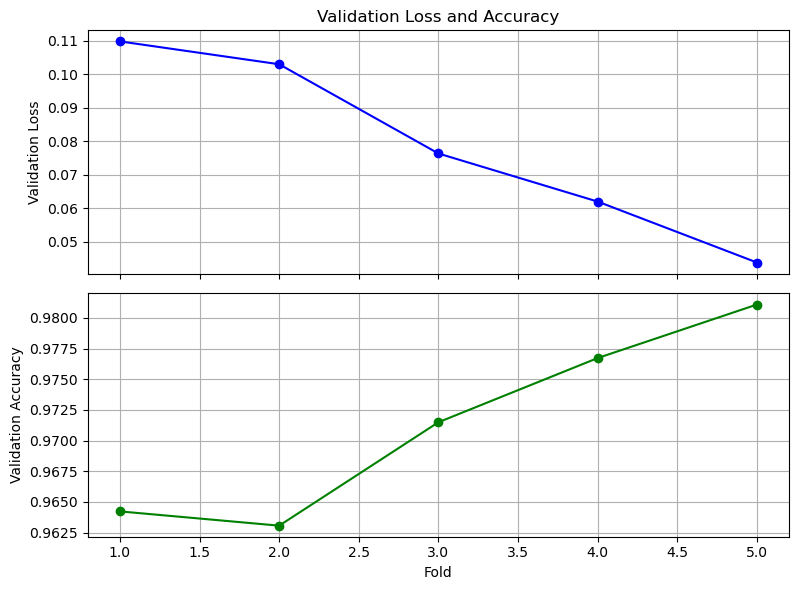

In [65]:
# plotting
plot_validation_metrics(val_losses, val_accs)
# saving losses and accs history for comparision in the future
append_to_val_dict(65, val_losses, val_accs)

학습 완료된 경우 바로 스프레드시트에 적어주세요!
한 데이터셋에 너무 시간을 많이 쓰실 필요는 없습니다. 학습할 내용도 많고 다른 모델도 많이 테스트해봐야 해요.
그리고 학습은 각 데이터셋에 대해 시간이 어느정도 소요되기 때문에 학습 과정에서는 다른 공부 하시는걸 추천드립니다.

In [67]:
print(val_losses)
print(val_accs)
val_dict

[0.10982047766447067, 0.10299540311098099, 0.07634427398443222, 0.061980895698070526, 0.04378343001008034]
[0.9642233848571777, 0.9630599021911621, 0.9714950323104858, 0.9767306447029114, 0.9810936450958252]


{65: ([0.10982047766447067,
   0.10299540311098099,
   0.07634427398443222,
   0.061980895698070526,
   0.04378343001008034],
  [0.9642233848571777,
   0.9630599021911621,
   0.9714950323104858,
   0.9767306447029114,
   0.9810936450958252])}

In [71]:
import csv
import os

data = {
    65: ([0.10982047766447067,
          0.10299540311098099,
          0.07634427398443222,
          0.061980895698070526,
          0.04378343001008034],
         [0.9642233848571777,
          0.9630599021911621,
          0.9714950323104858,
          0.9767306447029114,
          0.9810936450958252]),
    30: ([0.10982047766447067,
          0.10299540311098099,
          0.07634427398443222,
          0.061980895698070526,
          0.04378343001008034],
         [0.9642233848571777,
          0.9630599021911621,
          0.9714950323104858,
          0.9767306447029114,
          0.9810936450958252])
}

# CSV 파일에 저장할 데이터 준비
csv_data = []
for key, (val1, val2) in data.items():
    csv_data.append([key] + val1 + val2)

# 파일 저장 경로
csv_file_path = "output.csv"

# CSV 파일에 저장
file_exists = os.path.isfile(csv_file_path)

with open(csv_file_path, 'a', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    if not file_exists:
        # 헤더 추가
        header = ['index', 'fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'mean_fold', 'acc1', 'acc2', 'acc3', 'acc4', 'acc5', 'mean_acc']
        csvwriter.writerow(header)
    for row in csv_data:
        csvwriter.writerow(row)

print(f"Data has been appended to {csv_file_path}")


Data has been appended to output.csv
